# Exercise 1 - A one neuron neural network

# Q1: Implementing Multilinear regression

Imports:

In [147]:
import torch
from torch import nn
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
torch.manual_seed(42)

## Implementing a nn module and the forward function

For linear regression our implementation was:

In [155]:
class LinearRegression(nn.Module):
  def __init__(self):
    super(LinearRegression, self).__init__()
    self.w = torch.nn.Parameter(torch.randn(1))
    self.b = torch.nn.Parameter(torch.randn(1))

  def forward(self, x):
    return self.w * x + self.b

### Write your implementation for multilinear regression here:

In [156]:
class MultilinearRegression(nn.Module):
    def __init__(self, in_features):
        super(MultilinearRegression, self).__init__()
        self.weights = torch.nn.Parameter(torch.randn([1,in_features]))
        self.bias = torch.nn.Parameter(torch.randn(1))


    def forward(self, X):
        return torch.matmul(X,self.weights.T) + self.bias


**Note:** Remember to use **vectorization** whenever you can

### Test your implementation.

#### Look at the weights and bias:

In [157]:
model = MultilinearRegression(3)

In [158]:
print(model.weights)
print(model.bias)

Parameter containing:
tensor([[-1.1229, -0.1863,  2.2082]], requires_grad=True)
Parameter containing:
tensor([-0.6380], requires_grad=True)


In [159]:
for p in model.parameters():
    print(p)

Parameter containing:
tensor([[-1.1229, -0.1863,  2.2082]], requires_grad=True)
Parameter containing:
tensor([-0.6380], requires_grad=True)


In [160]:
print(model.state_dict())

OrderedDict([('weights', tensor([[-1.1229, -0.1863,  2.2082]])), ('bias', tensor([-0.6380]))])


In [161]:
print(model.state_dict()['weights'])

tensor([[-1.1229, -0.1863,  2.2082]])


In [162]:
print(model.state_dict()['bias'])

tensor([-0.6380])


In [163]:
print(model.state_dict().keys())

odict_keys(['weights', 'bias'])


In [164]:
print(model.state_dict().values())

odict_values([tensor([[-1.1229, -0.1863,  2.2082]]), tensor([-0.6380])])


#### Compare with PyTorch's built in module nn.Linear

In [165]:
m1 = nn.Linear(3, 1)

In [166]:
print(m1.weight)
print(m1.bias)

Parameter containing:
tensor([[ 0.4451,  0.0853, -0.2695]], requires_grad=True)
Parameter containing:
tensor([0.1472], requires_grad=True)


In [167]:
m2 = MultilinearRegression(3)

In [168]:
x = torch.randn(1, 3)

In [169]:
m1(x), m2(x)

(tensor([[-0.5676]], grad_fn=<AddmmBackward0>),
 tensor([[0.0245]], grad_fn=<AddBackward0>))

In [170]:
for p1, p2 in zip(m1.parameters(), m2.parameters()):
    p2.data = p1.data

In [171]:
m1(x), m2(x)

(tensor([[-0.5676]], grad_fn=<AddmmBackward0>),
 tensor([[-0.5676]], grad_fn=<AddBackward0>))

## The MSE cost function

### Your implementaiton

In [172]:
def MSE(y_hat, y):
    return 0.5*(((y_hat-y)**2).mean())

### Test

In [393]:
y = torch.tensor([[10.]])
y_hat = torch.tensor([[9.]])

2*MSE(y, y_hat), nn.MSELoss()(y, y_hat)

(tensor(1.), tensor(1.))

Remember we multiplied the MSE by 0.5, to make the constant drops in derivation.

In [394]:
y = torch.tensor([[10.], [1.]])
y_hat = torch.tensor([[9.], [3.]])

2*MSE(y, y_hat), nn.MSELoss()(y, y_hat)

(tensor(2.5000), tensor(2.5000))

## Computing the gradient

Remember the exercise from class:

Compute the partial derivatives of:
$$
\mathcal{L} = 0.5\cdot(w^tx+b-y)^2,
$$
with respect to the parameters $w = (w_1,w_2,\ldots,w_n)$ and $b$. The gradient $\nabla \mathcal{L}$ is the vector of these derivatives. And $\nabla \mathcal{L}(w)$ is the vector:
$$
\nabla \mathcal{L}(w) =
(\frac{\partial \mathcal{L}}{\partial w_1}, \frac{\partial \mathcal{L}}{\partial w_2}, \ldots,\frac{\partial \mathcal{L}}{\partial w_n} )
$$

And the solution:

$\frac{\partial \mathcal{L}}{\partial w_i} = (w^tx+b-y)x_i = (\hat{y}-y)x_i$

$\nabla \mathcal{L} = (w^tx+b-y)x = (\hat{y}-y)x$

$\frac{\partial \mathcal{L}}{\partial b} = (w^tx+b-y) = (\hat{y}-y)$


Remember that then we have $\nabla \mathcal{J} = \frac{1}{m}\nabla \mathcal{L}$, by linearity of the gradient function.

### Your implementation

In [173]:
def gradient(y_hat, X, Y):
  grad_bias= (y_hat-Y).mean()
  grad_weights=((y_hat-Y).T @ X)/X.shape[0]
  return  grad_weights, grad_bias


### Test: compare with PyTorch's autograd

In [174]:
model = MultilinearRegression(3)

In [175]:
X = torch.randn(10, 3)
Y = X@torch.randn(3,1) - 1 + torch.randn(10, 1)

In [176]:
Y_hat = model(X)
l = MSE(Y_hat, Y)

In [177]:
l.backward()
model.weights.grad, model.bias.grad

(tensor([[-0.4738, -0.3983, -0.6183]]), tensor([2.1235]))

In [178]:
gradient(Y_hat, X, Y)

(tensor([[-0.4738, -0.3983, -0.6183]], grad_fn=<DivBackward0>),
 tensor(2.1235, grad_fn=<MeanBackward0>))

## Implementing gradient descent

#### Your implementation:

In [179]:
def train(model, X, Y, epochs, learning_rate):
    for epoch in range(epochs):
        # Forward pass: compute predictions
        Y_hat = model(X)

        # Compute loss
        l = MSE(Y_hat, Y)

        # Backward pass: compute gradients
        l.backward()

        # Update weights and bias
        with torch.no_grad():
            model.weights -= learning_rate * model.weights.grad
            model.bias -= learning_rate * model.bias.grad

        # Zero gradients after update
        model.weights.grad.zero_()
        model.bias.grad.zero_()

        # Print loss for each epoch
        print(f"Epoch: {epoch}, Loss: {l.item()}")


### Test: use torch.optim

In [180]:
def train_optim(model, X, Y, epochs, learning_rate):
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
    for epoch in range(epochs):
        Y_hat = model(X)
        l = MSE(Y_hat, Y)
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        print(f"Epoch: {epoch}, Loss: {l}")

In [181]:
torch.manual_seed(1)
model = MultilinearRegression(3)
X = torch.randn(10, 3)
Y = X@torch.randn(3,1) - 1 + torch.randn(10, 1)

In [182]:
train(model, X, Y, 5, 0.01)

Epoch: 0, Loss: 3.087578296661377
Epoch: 1, Loss: 3.044194459915161
Epoch: 2, Loss: 3.0018668174743652
Epoch: 3, Loss: 2.960562229156494
Epoch: 4, Loss: 2.92024827003479


In [183]:
print(model.weights)
print(model.bias)

Parameter containing:
tensor([[0.7498, 0.2586, 0.0314]], requires_grad=True)
Parameter containing:
tensor([0.5816], requires_grad=True)


In [185]:
torch.manual_seed(1)
model = MultilinearRegression(3)
X = torch.randn(10, 3)
Y = X@torch.randn(3,1) - 1 + torch.randn(10, 1)

In [186]:
train_optim(model, X, Y, 5, 0.01)

Epoch: 0, Loss: 3.087578296661377
Epoch: 1, Loss: 3.044194459915161
Epoch: 2, Loss: 3.0018668174743652
Epoch: 3, Loss: 2.960562229156494
Epoch: 4, Loss: 2.92024827003479


In [187]:
print(model.weights)
print(model.bias)

Parameter containing:
tensor([[0.7498, 0.2586, 0.0314]], requires_grad=True)
Parameter containing:
tensor([0.5816], requires_grad=True)


## Create some data

In [188]:
class Dataset(torch.utils.data.Dataset):
    def __init__(self):
        self.X = torch.randn(10, 3)
        self.Y = self.X@torch.randn(3,1) - 1 + torch.randn(10, 1)

    def __getitem__(self, idx):
        return self.X[idx], self.Y[idx]

    def __len__(self):
        return self.X[0]


## Puting it all together - the learning model

In [189]:
class LearningModel():
    def __init__(self):

        self.data = Dataset()
        self.model = MultilinearRegression(in_features=X.data.shape[1])
        self.criterion = MSE


    @staticmethod
    def plotLoss(loss):

        import matplotlib.pyplot as plt
        plt.plot(loss)
        plt.title("Loss over Epochs")
        plt.xlabel("Epoch")
        plt.ylabel("Loss")
        plt.show()

    def train(self, epochs, learning_rate):

        loss = []
        for epoch in range(epochs):
            # Get X, Y from dataset
            X, Y = self.data.X, self.data.Y

            # Predictions
            y_hat = self.model(X)

            # Calculate loss
            l = self.criterion(y_hat, Y)

            # Compute gradients
            l.backward()

            # Update weights and bias
            with torch.no_grad():
                self.model.weights -= learning_rate * self.model.weights.grad
                self.model.bias -= learning_rate * self.model.bias.grad

            # Reset gradients
            self.model.weights.grad.zero_()
            self.model.bias.grad.zero_()

            # Store loss
            loss.append(l.item())
            print(f"Epoch: {epoch}, Loss: {l.item()}")

        return loss


In [190]:
torch.manual_seed(1)
lm = LearningModel()
l = lm.train(5, 0.01)

Epoch: 0, Loss: 2.0201728343963623
Epoch: 1, Loss: 1.9795290231704712
Epoch: 2, Loss: 1.940289855003357
Epoch: 3, Loss: 1.9024031162261963
Epoch: 4, Loss: 1.8658173084259033


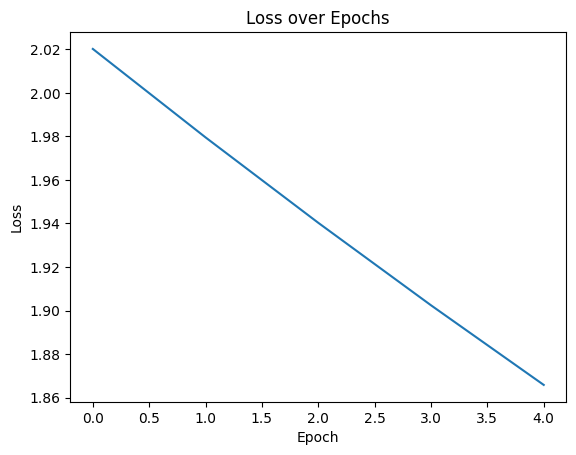

In [191]:
lm.plotLoss(l)

# Q2: Experiments

### Q2A: Use multilinear regression on real life problems/datasets.

The aim here is to train your model on a regression dataset. There are many you can find online, here are a few options:


1.   [Kaggle datasets](https://www.kaggle.com/datasets)
2.   [California Housing - from sklearn](https://scikit-learn.org/1.5/modules/generated/sklearn.datasets.fetch_california_housing.html#sklearn.datasets.fetch_california_housing)
3. [UCI Machine Learning Repository](https://archive.ics.uci.edu/datasets)
4. [And many more](https://www.telusdigital.com/insights/ai-data/article/10-open-datasets-for-linear-regression)



Epoch: 0, Loss: 7.597715854644775
Epoch: 1, Loss: 7.36944580078125
Epoch: 2, Loss: 7.148832321166992
Epoch: 3, Loss: 6.935605525970459
Epoch: 4, Loss: 6.729510307312012
Epoch: 5, Loss: 6.530298233032227
Epoch: 6, Loss: 6.337728977203369
Epoch: 7, Loss: 6.1515727043151855
Epoch: 8, Loss: 5.9716057777404785
Epoch: 9, Loss: 5.797614097595215
Epoch: 10, Loss: 5.629391193389893
Epoch: 11, Loss: 5.466737270355225
Epoch: 12, Loss: 5.309459686279297
Epoch: 13, Loss: 5.15737247467041
Epoch: 14, Loss: 5.01029634475708
Epoch: 15, Loss: 4.868060111999512
Epoch: 16, Loss: 4.730495929718018
Epoch: 17, Loss: 4.597442150115967
Epoch: 18, Loss: 4.468745231628418
Epoch: 19, Loss: 4.3442559242248535
Epoch: 20, Loss: 4.22382926940918
Epoch: 21, Loss: 4.107326507568359
Epoch: 22, Loss: 3.9946129322052
Epoch: 23, Loss: 3.885559320449829
Epoch: 24, Loss: 3.780041217803955
Epoch: 25, Loss: 3.6779375076293945
Epoch: 26, Loss: 3.579132556915283
Epoch: 27, Loss: 3.483513832092285
Epoch: 28, Loss: 3.3909730911254

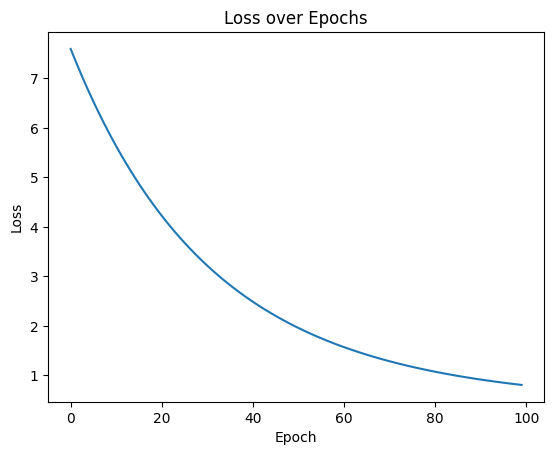

Test Loss: 0.8827938437461853


In [192]:
import numpy as np
from sklearn.datasets import fetch_california_housing
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

# Download the data
data = fetch_california_housing()
X, Y = data.data, data.target

# Split into training and test sets (80% for training, 20% for testing)
X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=0.2, random_state=42)

# Normalize the data
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

# Convert the data to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
Y_train_tensor = torch.tensor(Y_train, dtype=torch.float32).view(-1, 1)
Y_test_tensor = torch.tensor(Y_test, dtype=torch.float32).view(-1, 1)

# Create the model with the number of features in the data
learning_model = LearningModel()

# Set the data in the LearningModel class
learning_model.data.X = X_train_tensor
learning_model.data.Y = Y_train_tensor

# Train the model
loss = learning_model.train(epochs=100, learning_rate=0.01)

# Plot the loss over the epochs
learning_model.plotLoss(loss)

# Make predictions on the test set
y_pred = learning_model.model(X_test_tensor)

# Calculate the loss on the test set
test_loss = learning_model.criterion(y_pred, Y_test_tensor)
print(f'Test Loss: {test_loss.item()}')


### Q2B: Study the affect of the learning rate on the learning process.

Epoch: 0, Loss: 7.645617961883545
Epoch: 1, Loss: 7.644072532653809
Epoch: 2, Loss: 7.642525672912598
Epoch: 3, Loss: 7.640979766845703
Epoch: 4, Loss: 7.639434814453125
Epoch: 5, Loss: 7.637889862060547
Epoch: 6, Loss: 7.636344909667969
Epoch: 7, Loss: 7.634800910949707
Epoch: 8, Loss: 7.633257865905762
Epoch: 9, Loss: 7.6317138671875
Epoch: 10, Loss: 7.6301703453063965
Epoch: 11, Loss: 7.628628253936768
Epoch: 12, Loss: 7.627086162567139
Epoch: 13, Loss: 7.625543117523193
Epoch: 14, Loss: 7.624001979827881
Epoch: 15, Loss: 7.622460842132568
Epoch: 16, Loss: 7.620919704437256
Epoch: 17, Loss: 7.61937952041626
Epoch: 18, Loss: 7.617839336395264
Epoch: 19, Loss: 7.616299629211426
Epoch: 20, Loss: 7.614760398864746
Epoch: 21, Loss: 7.613221168518066
Epoch: 22, Loss: 7.611682891845703
Epoch: 23, Loss: 7.610144138336182
Epoch: 24, Loss: 7.608606338500977
Epoch: 25, Loss: 7.607068061828613
Epoch: 26, Loss: 7.605531215667725
Epoch: 27, Loss: 7.603993892669678
Epoch: 28, Loss: 7.6024565696716

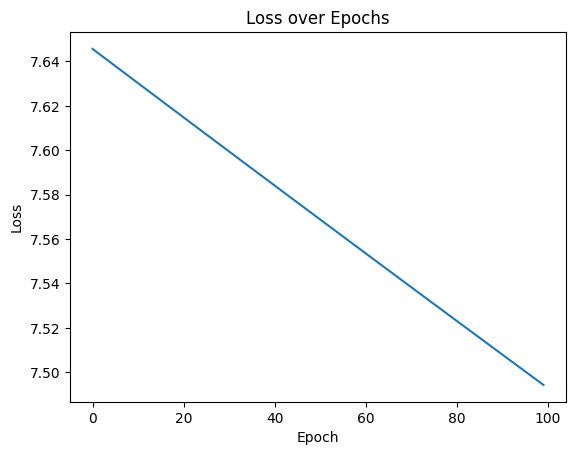

Test Loss: 7.711705684661865
Epoch: 0, Loss: 7.492770671844482
Epoch: 1, Loss: 7.342610836029053
Epoch: 2, Loss: 7.195951461791992
Epoch: 3, Loss: 7.052701950073242
Epoch: 4, Loss: 6.912770748138428
Epoch: 5, Loss: 6.776073932647705
Epoch: 6, Loss: 6.642526149749756
Epoch: 7, Loss: 6.512044906616211
Epoch: 8, Loss: 6.384551525115967
Epoch: 9, Loss: 6.259968280792236
Epoch: 10, Loss: 6.13822078704834
Epoch: 11, Loss: 6.019237041473389
Epoch: 12, Loss: 5.9029459953308105
Epoch: 13, Loss: 5.789278030395508
Epoch: 14, Loss: 5.678167343139648
Epoch: 15, Loss: 5.569549560546875
Epoch: 16, Loss: 5.46336030960083
Epoch: 17, Loss: 5.359539985656738
Epoch: 18, Loss: 5.258028507232666
Epoch: 19, Loss: 5.158768653869629
Epoch: 20, Loss: 5.061703205108643
Epoch: 21, Loss: 4.966777801513672
Epoch: 22, Loss: 4.873940467834473
Epoch: 23, Loss: 4.783139705657959
Epoch: 24, Loss: 4.694323539733887
Epoch: 25, Loss: 4.607445240020752
Epoch: 26, Loss: 4.52245569229126
Epoch: 27, Loss: 4.439309597015381
Epo

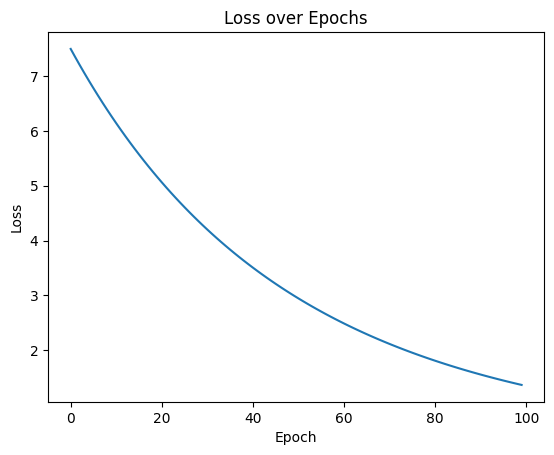

Test Loss: 1.331490159034729
Epoch: 0, Loss: 1.3508689403533936
Epoch: 1, Loss: 1.1712485551834106
Epoch: 2, Loss: 1.0232871770858765
Epoch: 3, Loss: 0.9010014533996582
Epoch: 4, Loss: 0.7996297478675842
Epoch: 5, Loss: 0.7153619527816772
Epoch: 6, Loss: 0.645131528377533
Epoch: 7, Loss: 0.5864588618278503
Epoch: 8, Loss: 0.5373300909996033
Epoch: 9, Loss: 0.49610400199890137
Epoch: 10, Loss: 0.4614379107952118
Epoch: 11, Loss: 0.43223002552986145
Epoch: 12, Loss: 0.4075738787651062
Epoch: 13, Loss: 0.38672155141830444
Epoch: 14, Loss: 0.36905431747436523
Epoch: 15, Loss: 0.3540594279766083
Epoch: 16, Loss: 0.3413107991218567
Epoch: 17, Loss: 0.3304538428783417
Epoch: 18, Loss: 0.32119256258010864
Epoch: 19, Loss: 0.3132796585559845
Epoch: 20, Loss: 0.3065081238746643
Epoch: 21, Loss: 0.3007041811943054
Epoch: 22, Loss: 0.2957218289375305
Epoch: 23, Loss: 0.29143816232681274
Epoch: 24, Loss: 0.28774961829185486
Epoch: 25, Loss: 0.2845686078071594
Epoch: 26, Loss: 0.28182101249694824
Ep

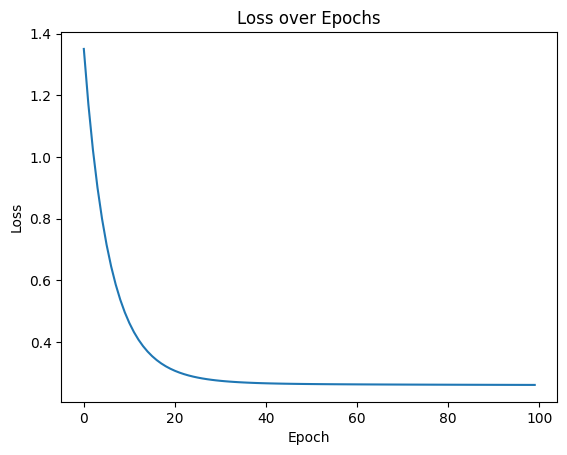

Test Loss: 0.27416515350341797


In [193]:


# Create the model with the number of features in the data
learning_model = LearningModel()

# Set the data in the LearningModel class
learning_model.data.X = X_train_tensor
learning_model.data.Y = Y_train_tensor

# Train the model
learning_rates = [0.0001, 0.01, 0.1]
for lr in learning_rates:
  loss = learning_model.train(epochs=100, learning_rate=lr)

  # Plot the loss over the epochs
  learning_model.plotLoss(loss)

  # Make predictions on the test set
  y_pred = learning_model.model(X_test_tensor)

  # Calculate the loss on the test set
  test_loss = learning_model.criterion(y_pred, Y_test_tensor)
  print(f'Test Loss: {test_loss.item()}')


# Q3: Implementing logistic regrssion

Same as above, implement a one-neuron neural network with arbitrary number of features. But this time add a logistic activation function, and thus implement logistic regression.

Test your implementation on real world data.

Try both MSE and BCE loss/cost funciton.

In [144]:
import pandas as pd
from sklearn.datasets import fetch_openml
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import torch
import torch.nn as nn

# Custom BCE loss function
def BCE(y_hat, y):
    return -torch.mean(y * torch.log(y_hat) + (1 - y) * torch.log(1 - y_hat))

# Custom MSE loss function
def MSE(y_hat, y):
    return torch.mean((y_hat - y) ** 2)

# Logistic Regression model
class LogisticRegressionModel(nn.Module):
    def __init__(self, input_dim):
        super(LogisticRegressionModel, self).__init__()
        self.weights = nn.Parameter(torch.randn(input_dim, 1))
        self.bias = nn.Parameter(torch.randn(1))

    def forward(self, x):
        return torch.sigmoid(torch.matmul(x, self.weights) + self.bias)

# Load and preprocess data
data = fetch_openml("heart-disease", version=1)
df = data.frame
X = df.drop('target', axis=1)
Y = df['target']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, Y, test_size=0.2, random_state=42)

# Convert to PyTorch tensors
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.values, dtype=torch.float32).view(-1, 1)
y_test_tensor = torch.tensor(y_test.values, dtype=torch.float32).view(-1, 1)

# Train the model
def train_model(model, X_train, y_train, loss_function='MSE', epochs=100, learning_rate=0.01):
    criterion = MSE if loss_function == 'MSE' else BCE
    loss_history = []

    for epoch in range(epochs):
        y_hat = model(X_train)
        loss = criterion(y_hat, y_train)
        loss.backward()

        with torch.no_grad():
            model.weights -= learning_rate * model.weights.grad
            model.bias -= learning_rate * model.bias.grad

        model.weights.grad.zero_()
        model.bias.grad.zero_()

        loss_history.append(loss.item())

        if (epoch + 1) % 10 == 0:
            print(f"Epoch {epoch+1}/{epochs}, Loss: {loss.item()}")

    return loss_history

# Create and train models
input_dim = X_train_tensor.shape[1]
model_mse = LogisticRegressionModel(input_dim)
print("Training with MSE Loss:")
loss_history_mse = train_model(model_mse, X_train_tensor, y_train_tensor, loss_function='MSE')

model_bce = LogisticRegressionModel(input_dim)
print("Training with BCE Loss:")
loss_history_bce = train_model(model_bce, X_train_tensor, y_train_tensor, loss_function='BCE')


Training with MSE Loss:
Epoch 10/100, Loss: 0.6503040790557861
Epoch 20/100, Loss: 0.6495440602302551
Epoch 30/100, Loss: 0.6487804651260376
Epoch 40/100, Loss: 0.6480132341384888
Epoch 50/100, Loss: 0.6472424864768982
Epoch 60/100, Loss: 0.6464682221412659
Epoch 70/100, Loss: 0.6456906795501709
Epoch 80/100, Loss: 0.6449097990989685
Epoch 90/100, Loss: 0.644125759601593
Epoch 100/100, Loss: 0.6433385014533997
Training with BCE Loss:
Epoch 10/100, Loss: 2.5198755264282227
Epoch 20/100, Loss: 2.4350783824920654
Epoch 30/100, Loss: 2.3528692722320557
Epoch 40/100, Loss: 2.273263692855835
Epoch 50/100, Loss: 2.1962742805480957
Epoch 60/100, Loss: 2.1218864917755127
Epoch 70/100, Loss: 2.0500876903533936
Epoch 80/100, Loss: 1.9808539152145386
Epoch 90/100, Loss: 1.9141525030136108
Epoch 100/100, Loss: 1.8499467372894287


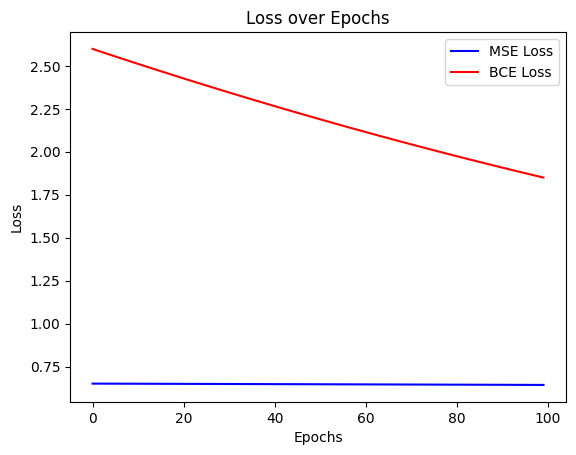

In [145]:
import matplotlib.pyplot as plt


plt.plot(loss_history_mse, label='MSE Loss', color='blue')
plt.plot(loss_history_bce, label='BCE Loss', color='red')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Loss over Epochs')
plt.legend()
plt.show()
